In [64]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool

import numpy as np
import matplotlib.pyplot as plt

#sys.path.insert(0,'/groups/astro/robinboe/mass_analysis')
#sys.path.insert(0,'/groups/astro/robinboe/mass_analysis/computable-information-density')
#from joblib import Parallel, delayed

from ComputableInformationDensity.cid import interlaced_time, cid2d
from ComputableInformationDensity.computable_information_density import cid

# Get absolute path to this notebook
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean

In [3]:
base_path = f'Z:\\cid\\na{512}'
os.listdir(base_path) 

act_list = [float(os.listdir(base_path)[i].split('_')[-1]) for i in range(len(os.listdir(base_path)))]
act_list.sort()
act_list

[0.0195,
 0.02,
 0.02,
 0.0205,
 0.021,
 0.0215,
 0.022,
 0.0225,
 0.023,
 0.0235,
 0.024]

In [14]:
act_dir_list = [os.path.join(base_path, os.listdir(base_path)[i]) for i in range(len(os.listdir(base_path)))]
act_list = [float(os.listdir(base_path)[i].split('_')[-1]) for i in range(len(os.listdir(base_path)))]

act_list[1] = 0.21
# sort act_list and act_dir_list by act_list
act_dir_list = [x for _, x in sorted(zip(act_list, act_dir_list))]



act_list

[0.0195, 0.21, 0.0205, 0.021, 0.0215, 0.022, 0.0225, 0.023, 0.0235, 0.024]

In [71]:
extract = True
cid_suff = 'full'

## !! NB hardcoded parameters !!
nhilbert_views = 8
nshuffle = 8

LL = 512
nframes = 32
nexp=5
exp_list = [i for i in range(nexp)]

base_path = f'Z:\\cid\\na{LL}'
outpath = f'data\\nematic\\na{LL}'
if not os.path.exists(outpath):
    os.makedirs(outpath)

act_dir_list = [os.path.join(base_path, os.listdir(base_path)[i]) for i in range(len(os.listdir(base_path)))]
act_list = [float(os.listdir(base_path)[i].split('_')[-1]) for i in range(len(os.listdir(base_path)))]

act_list.sort()
act_dir_list = [x for _, x in sorted(zip(act_list, act_dir_list))]

cid_arr = np.zeros((len(act_list), nexp, 2))
cid_shuffle_arr = np.zeros((len(act_list), nexp, 2))
cid_frac_arr = np.zeros((len(act_list), nexp, 2))

if extract:

    for i, act_dir in enumerate(act_dir_list):
        exp_dir_list = [os.path.join(act_dir, os.listdir(act_dir)[j]) for j in range(len(os.listdir(act_dir)))]
        exp_dir_list = [x for _, x in sorted(zip(exp_list, exp_dir_list))]
        for j, exp_dir in enumerate(exp_dir_list):
            # load cid.pkl if it exists
            with open(os.path.join(exp_dir, f'cid_{cid_suff}.pkl'), 'rb') as f:
                cid_dict = pkl.load(f)

            # extract cid values
            cid_arr[i, j, :] = cid_dict['cid']
            cid_shuffle_arr[i, j, :] = cid_dict['cid_shuffle']

    # converts stds to sems
    cid_arr[:,:,1 ] = cid_arr[:,:,1] / np.sqrt(nhilbert_views)
    cid_shuffle_arr[:,:,1 ] = cid_shuffle_arr[:,:,1] / np.sqrt(nshuffle)

cid_frac_arr[:,:,0] = cid_arr[:,:,0] / cid_shuffle_arr[:,:,0]
cid_frac_arr[:,:,1] = cid_frac_arr[:,:,0] * np.sqrt( (cid_arr[:,:,1]/cid_arr[:,:,0])**2 + (cid_shuffle_arr[:,:,1]/cid_shuffle_arr[:,:,0])**2 )


In [57]:
X=np.ones((3,3))
X[-1,-1]=0
mask = (X==0)
X[mask]=np.std(X[~mask],axis=-1)
X,np.std(X[~mask],axis=-1)

(array([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 0.]]),
 0.0)

In [ ]:
div = cid_arr[:,:,0] / cid_shuffle_arr[:,:,0]

cid_ratio_std = np.sqrt((cid_std)**2 + (cid_ratio)**2 * (cid_shuffle_std)**2) / cid_shuffle_mean

In [115]:

divdz = np.diff(1 - cid_frac_arr[:,:,0], axis=0, prepend=0) / np.diff(act_list, prepend=0)[:,None]


In [125]:
act_expanded = np.repeat(np.array(act_list)[:,None], nexp, axis=1)
act_expanded

array([[0.0195, 0.0195, 0.0195, 0.0195, 0.0195],
       [0.02  , 0.02  , 0.02  , 0.02  , 0.02  ],
       [0.0205, 0.0205, 0.0205, 0.0205, 0.0205],
       [0.021 , 0.021 , 0.021 , 0.021 , 0.021 ],
       [0.0215, 0.0215, 0.0215, 0.0215, 0.0215],
       [0.022 , 0.022 , 0.022 , 0.022 , 0.022 ],
       [0.0225, 0.0225, 0.0225, 0.0225, 0.0225],
       [0.023 , 0.023 , 0.023 , 0.023 , 0.023 ],
       [0.0235, 0.0235, 0.0235, 0.0235, 0.0235],
       [0.024 , 0.024 , 0.024 , 0.024 , 0.024 ]])

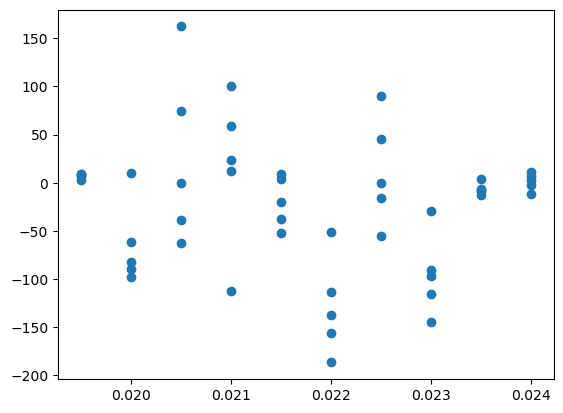

In [127]:
act_expanded = np.repeat(np.array(act_list)[:,None], nexp, axis=1)
plt.scatter(act_expanded, divdz, marker='o')

In [109]:
cid_frac_arr[:,1,0]

array([0.86579064, 0.86099673, 0.89221275, 0.88059938, 0.87598196,
       0.93274541, 0.93279314, 0.99069615, 0.98873841, 0.98755735])

In [90]:
cid_frac_arr[1,:,0]

array([1.        , 0.86099673, 0.84436973, 0.85833234, 0.89399531])

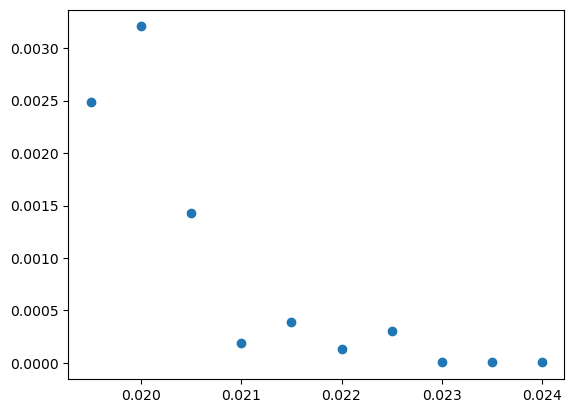

In [76]:
#plt.scatter(act_list, 1-np.mean(cid_frac_arr[:,:,0], axis=1))
plt.scatter(act_list, np.var(cid_frac_arr[:,:,0], axis=1))

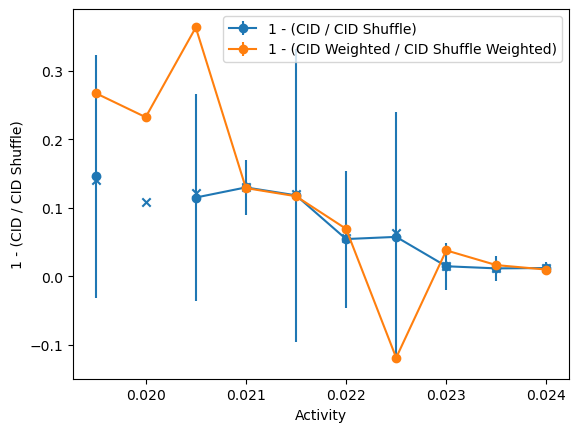

In [74]:
plot_divergence=True
nhilbert_views = 8
nshuffle = 8

cid_mean = np.mean(cid_arr[:,:,0], axis=1) 
cid_std = (np.std(cid_arr[:,:,0], axis=1) + np.mean(cid_arr[:,:,1], axis=1)) / np.sqrt(nexp)

cid_mean_weighted, cid_std_weighted = calc_weighted_mean(cid_arr[:,:,0], cid_arr[:,:,1], omit_null_uncertainties=True)
cid_shuffle_mean_weighted, cid_shuffle_std_weighted = calc_weighted_mean(cid_shuffle_arr[:,:,0], cid_shuffle_arr[:,:,1], omit_null_uncertainties=True)

cid_shuffle_mean = np.mean(cid_shuffle_arr[:,:,0], axis=1)
cid_shuffle_std = (np.std(cid_shuffle_arr[:,:,0], axis=1) + np.mean(cid_shuffle_arr[:,:,1], axis=1)) / np.sqrt(nexp)

cid_ratio = cid_mean / cid_shuffle_mean
cid_ratio_std = np.sqrt((cid_std)**2 + (cid_ratio)**2 * (cid_shuffle_std)**2) / cid_shuffle_mean

cid_ratio_weighted = cid_mean_weighted / cid_shuffle_mean_weighted  
cid_ratio_std_weighted = np.sqrt((cid_std_weighted)**2 + (cid_ratio_weighted)**2 * (cid_shuffle_std_weighted)**2) / cid_shuffle_mean_weighted

if plot_divergence:
    plt.scatter(act_list, 1-np.mean(cid_frac_arr[:,:,0], axis=1), marker='x')
    plt.errorbar(act_list, 1-cid_ratio, yerr=cid_ratio_std, label='1 - (CID / CID Shuffle)', fmt='o-')
    plt.errorbar(act_list, 1-cid_ratio_weighted, yerr=cid_ratio_std_weighted, label='1 - (CID Weighted / CID Shuffle Weighted)', fmt='o-')
    plt.ylabel('1 - (CID / CID Shuffle)')
else:
    plt.errorbar(act_list, cid_shuffle_mean_weighted, yerr=cid_shuffle_std_weighted, label='CID Shuffle Weighted', fmt='o-')
    plt.errorbar(act_list, cid_mean_weighted, yerr=cid_std_weighted, label='CID Weighted', fmt='o-')
    plt.errorbar(act_list, cid_shuffle_mean, yerr=cid_shuffle_std, label='CID Shuffle', fmt='o-')   
    plt.errorbar(act_list, cid_mean, yerr=cid_std, label='CID', fmt='o-')
    plt.ylabel('CID')
    #plt.errorbar(act_list, 1-cid_ratio, yerr=cid_ratio_std, label='1 - (CID / CID Shuffle)', fmt='o-')
#plt.plot(act_list, 1-cid_ratio, 'o-', label='1 - (CID / CID Shuffle)', )
plt.xlabel('Activity')
plt.legend()

Text(0, 0.5, '1 - (CID / CID Shuffle)')

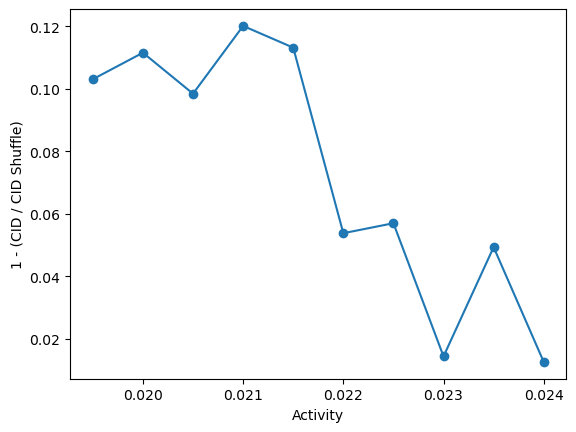

In [36]:
cid_mean = np.mean(cid_arr[:,:,0], axis=1)
cid_std = (np.std(cid_arr[:,:,0], axis=1) + np.mean(cid_arr[:,:,1], axis=1)) / np.sqrt(nexp)

cid_shuffle_mean = np.mean(cid_shuffle_arr[:,:,0], axis=1)
cid_shuffle_std = (np.std(cid_shuffle_arr[:,:,0], axis=1) + np.mean(cid_shuffle_arr[:,:,1], axis=1)) / np.sqrt(nexp)

cid_ratio = cid_mean / cid_shuffle_mean
cid_ratio_std = cid_ratio * np.sqrt((cid_std/cid_mean)**2 + (cid_shuffle_std/cid_shuffle_mean)**2)
cid_ratio_std = np.sqrt((cid_std)**2 + (cid_ratio)**2 * (cid_shuffle_std)**2) / cid_shuffle_mean

#plt.errorbar(act_list, cid_shuffle_mean, yerr=cid_shuffle_std, label='CID Shuffle', fmt='o-')   
#plt.errorbar(act_list, cid_mean, yerr=cid_std, label='CID', fmt='o-')
#plt.errorbar(act_list, 1-cid_ratio, yerr=cid_ratio_std, label='1 - (CID / CID Shuffle)', fmt='o-')
plt.plot(act_list, 1-cid_ratio, 'o-', label='1 - (CID / CID Shuffle)', )
plt.xlabel('Activity')
plt.ylabel('1 - (CID / CID Shuffle)')